# <h1 style= "color:#7496d6;"> Libraries</h1>

In [82]:
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings
from scipy.stats.contingency import association
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
from imblearn.over_sampling import SMOTE
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor # NEW!!!!
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import classification_report
from pandas import concat
from sklearn.metrics import confusion_matrix 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
warnings.filterwarnings("ignore")

# <h1 style= "color:#7496d6;">Data Extraction from Kaggle</h1>

In [83]:
# Download latest version
path = kagglehub.dataset_download("ealaxi/paysim1")

# Print all files in the dataset path
print(os.listdir(path))

['PS_20174392719_1491204439457_log.csv']


In [84]:
csv_file_path = os.path.join(path, 'PS_20174392719_1491204439457_log.csv')
data = pd.read_csv(csv_file_path)

# <h1 style= "color:#7496d6;">Data Understanding </h1>

# <h2 style= "color:#605f63;">Columns Descriptions </h2>

- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- amount - amount of the transaction in local currency.

- nameOrig - customer who started the transaction

- oldbalanceOrg - initial balance before the transaction

- newbalanceOrig - new balance after the transaction.

- nameDest - customer who is the recipient of the transaction

- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

NOTE: Transactions which are detected as fraud are cancelled, so for fraud detection these columns (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ) must not be used.

# <h2 style= "color:#605f63;">Data First Impression </h2>

In [85]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0


In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [87]:
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [88]:
data.duplicated().sum()

0

In [89]:
data.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

In [90]:
data['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [91]:
data.eq(' ').sum().sort_values(ascending=False)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

# <h1 style= "color:#7496d6;">Data Cleaning </h1>

NOTE: Transactions which are detected as fraud are cancelled, so for fraud detection these columns (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ) must not be used.

In [92]:
#Copping Data 
df = data.copy()

In [93]:
# Rename columns 
df.rename(columns= {'nameOrig': 'name_orig', 'nameDest': 'name_dest', 'isFraud': 'is_fraud', 'isFlaggedFraud': 'is_flagged_fraud', 'oldbalanceOrg': 'old_balance_org', 'newbalanceOrig':'new_balance_orig','oldbalanceDest':'old_balance_dest', 'newbalanceDest':'new_balance_dest' }, inplace=True)
df.columns

Index(['step', 'type', 'amount', 'name_orig', 'old_balance_org',
       'new_balance_orig', 'name_dest', 'old_balance_dest', 'new_balance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

# <h1 style= "color:#7496d6;">EDA (Exploratory Data Analysis) </h1>

In [94]:
cat = df.select_dtypes(exclude="number")
num = df.select_dtypes(include="number")

potencial_categorical_from_numerical = df.select_dtypes("number").loc[:, df.select_dtypes("number").nunique() < 20]

cat = pd.concat([cat, potencial_categorical_from_numerical], axis=1)

num.drop(columns=['is_fraud', 'is_flagged_fraud'], inplace=True)

In [95]:
df.describe().round(1)

,step,amount,old_balance_org,new_balance_orig,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.70,1100701.70,1224996.40,0.00,0.00
std,142.30,603858.20,2888242.70,2924048.50,3399180.10,3674128.90,0.00,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.60,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.90,14208.00,0.00,132705.70,214661.40,0.00,0.00
75%,335.00,208721.50,107315.20,144258.40,943036.70,1111909.20,0.00,0.00
max,743.00,92445516.60,59585040.40,49585040.40,356015889.40,356179278.90,1.00,1.00


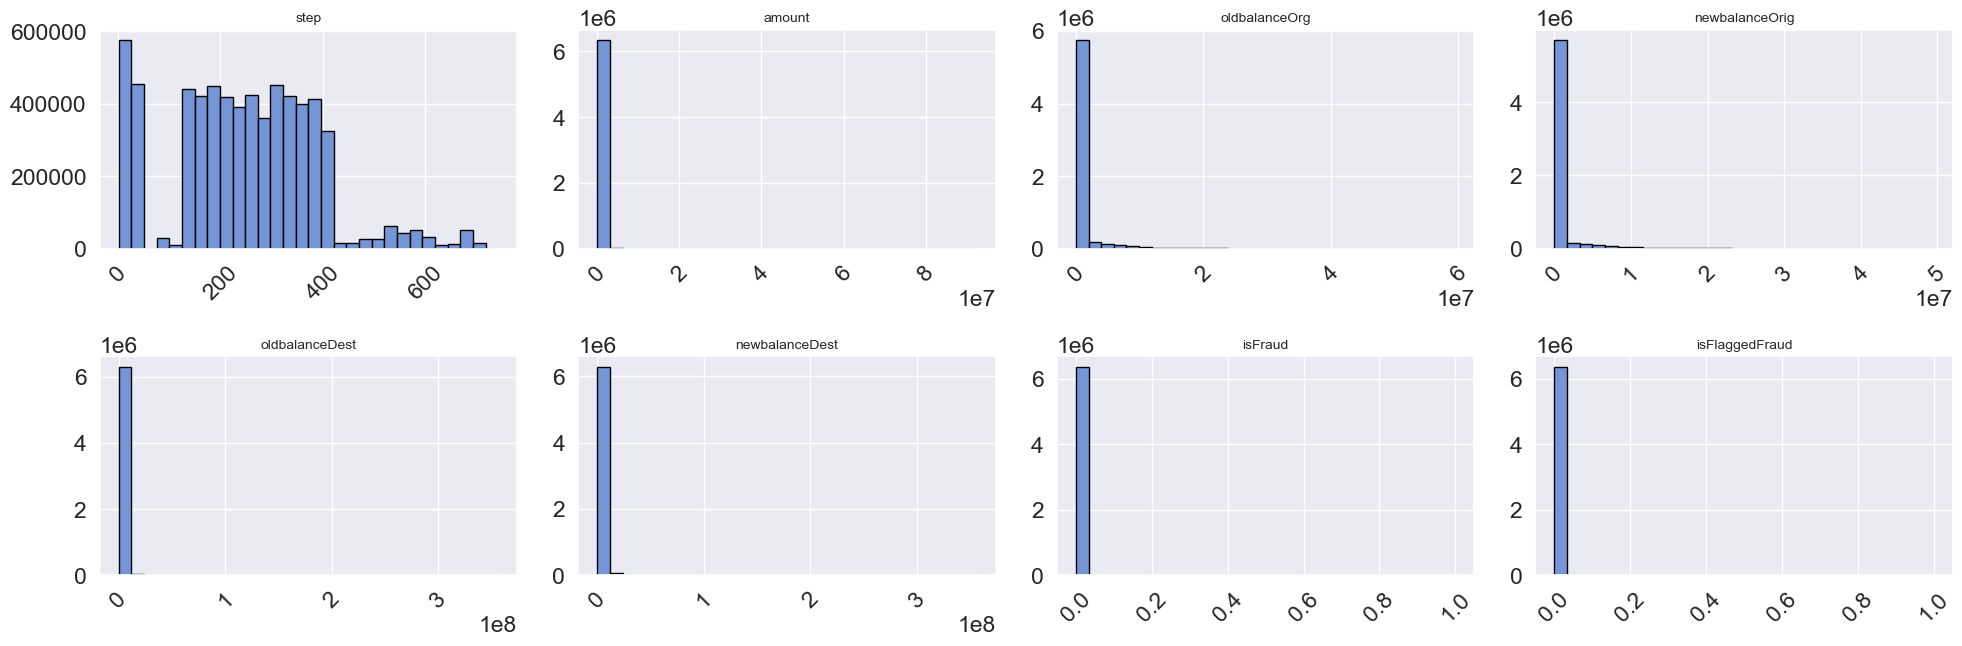

In [96]:
color = '#7496d6'
# Filter for numerical columns only
numerical_columns = data.select_dtypes(include=np.number).columns

# Grid size
nrows, ncols = 5, 4  # adjust for your number of features
num_features = len(numerical_columns)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))
axes = axes.flatten()

# Plot each numerical feature
for i, ax in enumerate(axes):
    if i >= num_features:  # Hide unused subplots
        ax.set_visible(False)
        continue
    column = numerical_columns[i]
    ax.hist(data[column], bins=30, color=color, edgecolor='black')
    ax.set_title(column, fontsize=10)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [97]:
num.amount.skew().round(2)

30.99

- Skewness > 0: The distribution is positively skewed (or right-skewed), meaning there is a longer tail on the right side of the distribution. The mass of the distribution is concentrated on the left of the figure.

In [98]:
num.amount.kurtosis().round(2)

1797.96

- Excess Kurtosis > 0 (or Kurtosis > 3): The distribution is leptokurtic. It has fatter tails and a sharper peak than the normal distribution, indicating more extreme values (outliers) than expected in a normal distribution.

- Skewness of 'amount': \(30.99\)
- Kurtosis of 'amount': \(1797.96\)



**Insights**:

- **Skewness**:
This exceptionally high positive skewness indicates an extremely right-skewed distribution. The vast majority of the data points are concentrated at the lower end of the 'amount' range, while a few extreme values on the higher end (outliers) are pulling the tail significantly to the right.
Such extreme skewness often points to data that has either a significant number of small values or a few massive outliers.

- **Kurtosis**:
The kurtosis value is extraordinarily high, far exceeding the typical threshold of 3 for a normal distribution. This indicates that the distribution has extremely heavy tails and a very sharp peak.
The high kurtosis suggests that outliers in the 'amount' data are not only present but are highly influential, dominating the overall distribution.


<Axes: xlabel='amount', ylabel='Count'>

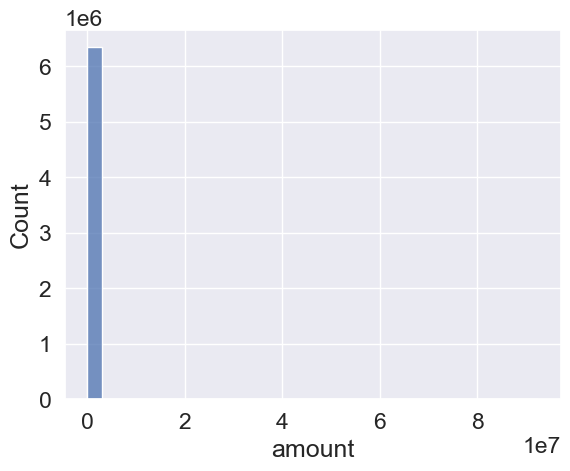

In [99]:
sns.histplot(num.amount, bins=30)

<Axes: ylabel='amount'>

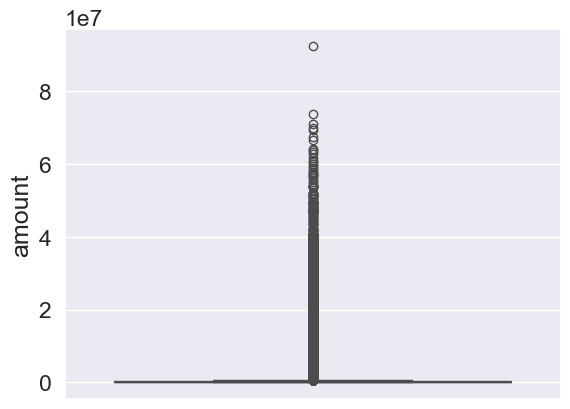

In [100]:
sns.boxplot(data=num.amount)

In [101]:
# Method 1: IQR-based Outlier Detection
def detect_outliers_iqr(df, num):
    outliers_iqr = {}
    for column in num:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers_iqr[column] = outliers
    return outliers_iqr

# Detect outliers
outliers_iqr = detect_outliers_iqr(df, num)

# Print outliers to check
print("Outliers detected using IQR method:")
for column, outliers in outliers_iqr.items():
    print(f"\n{column}: {len(outliers)} outliers detected")

Outliers detected using IQR method:

step: 102688 outliers detected

amount: 338078 outliers detected

old_balance_org: 1112507 outliers detected

new_balance_orig: 1053391 outliers detected

old_balance_dest: 786135 outliers detected

new_balance_dest: 738527 outliers detected


# <h3 style= "color:#008080;">Questions </h3>

##### 1. What is the freqencies of the types of transitions? 

In [102]:
frequency_table = cat['type'].value_counts()
proportion_table = cat['type'].value_counts(normalize=True).round(2)
type_proportion_table = pd.concat([frequency_table, proportion_table], axis= 1)
type_proportion_table

,count,proportion
type,,
CASH_OUT,2237500,0.35
PAYMENT,2151495,0.34
CASH_IN,1399284,0.22
TRANSFER,532909,0.08
DEBIT,41432,0.01


<Axes: xlabel='type', ylabel='count'>

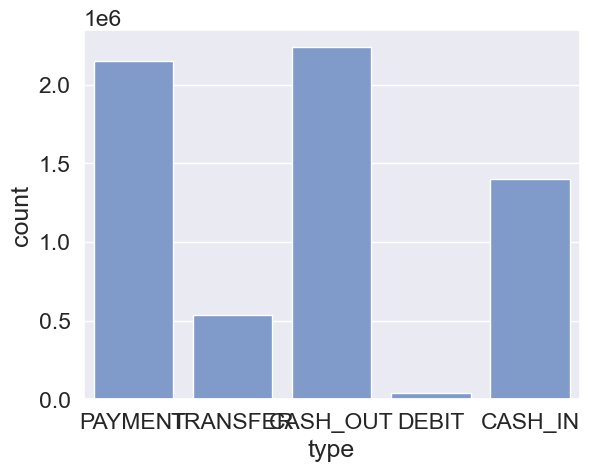

In [103]:
sns.countplot(data=df, x='type', color="#7496d6")

##### 2. Do flagged transactions (isFlaggedFraud) align with fraudulent transactions (isFraud), or is there a gap in detection accuracy?


In [104]:
flagged_fraud = df[df['is_flagged_fraud'] == 1]
total_flagged = len(flagged_fraud)
total_flagged_is_fraud = len(flagged_fraud[flagged_fraud['is_fraud'] == 1])
accuracy = (total_flagged_is_fraud / total_flagged) * 100

print(f"Total transactions flagged as fraud: {total_flagged}")
print(f"Of these, actual fraud transactions: {total_flagged_is_fraud}")
print(f"Accuracy of flagged fraud detection: {accuracy}%")

Total transactions flagged as fraud: 16
Of these, actual fraud transactions: 16
Accuracy of flagged fraud detection: 100.0%


##### 3. Does a high transaction amount (close to 200,000) have a strong relationship with fraud occurrence?

<Axes: ylabel='count'>

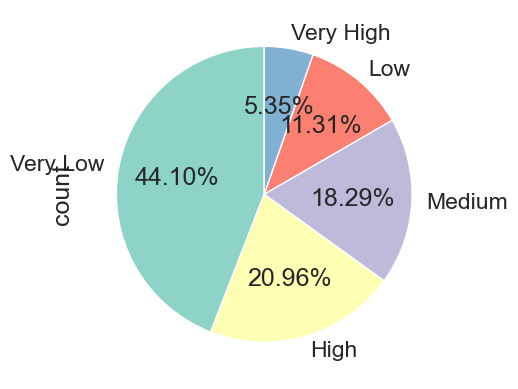

In [105]:
bins = [0, 50000, 100000, 200000, 500000, df.amount.max()]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

df['amount_map'] = pd.cut(df.amount, bins=bins, labels=labels)

freq = df.amount_map.value_counts()

freq.plot.pie(autopct='%1.2f%%' ,startangle=90, colors=sns.color_palette('Set3'))


##### 4. Which types of transactions are most susceptible to fraud?

In [106]:
fraud_types = df[df['is_fraud'] == 1].groupby('type').size().reset_index(name='fraud_count')
fraud_types

,type,fraud_count
0,CASH_OUT,4116
1,TRANSFER,4097


# <h2 style= "color:#605f63;">Inferential Analysis </h2>

In [107]:
null_hypothesis = "There is no association between the transaction amount categories (amount_map) and whether a transaction is fraudulent (is_fraud)."  # H₀
alt_hypothesis =  "There is an association between the transaction amount categories (amount_map) and whether a transaction is fraudulent (is_fraud)." # H₁

print(f"Null Hypothesis (H₀): {null_hypothesis}")
print(f"Alternate Hypothesis (H₁): {alt_hypothesis}")

Null Hypothesis (H₀): There is no association between the transaction amount categories (amount_map) and whether a transaction is fraudulent (is_fraud).
Alternate Hypothesis (H₁): There is an association between the transaction amount categories (amount_map) and whether a transaction is fraudulent (is_fraud).


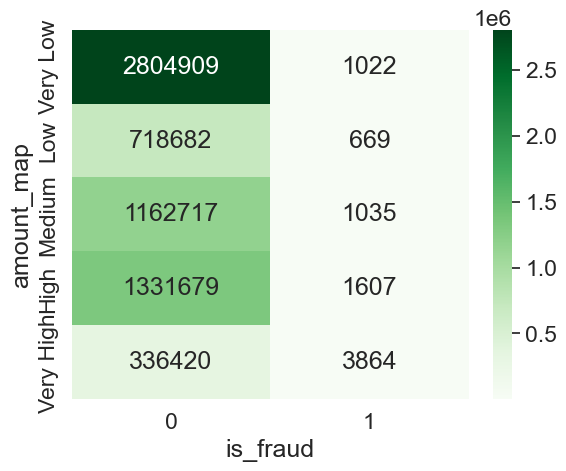

In [108]:
pd.crosstab(index=df.amount_map, 
            columns='count')

crosstab_result = pd.crosstab(df['amount_map'], df['is_fraud'])

sns.heatmap(crosstab_result, annot=True, cmap="Greens", fmt="d")
plt.show()

In [109]:
chi2_stats, chi2_pvalue, _, _ = chi2_contingency(crosstab_result)
chi2_pvalue < 0.05

if chi2_pvalue < 0.05:
    print("\nConclusion:")
    print("We reject the null hypothesis. There is a statistically significant association between the transaction amount categories (amount_map) and whether a transaction is fraudulent (is_fraud).")
else:
    print("\nConclusion:")
    print("We fail to reject the null hypothesis. There is no statistically significant association between the transaction amount categories (amount_map) and whether a transaction is fraudulent (is_fraud).")


Conclusion:
We reject the null hypothesis. There is a statistically significant association between the transaction amount categories (amount_map) and whether a transaction is fraudulent (is_fraud).


In [110]:
chi2_stats

28887.528873753155

In [111]:
chi2_pvalue

0.0

In [112]:
# Computing the association between variables in 'crosstab_result' using the "cramer" method
association(crosstab_result, method='cramer')

0.06738104610385756

The Cramer value of 0.067 suggests a **weak** association between two variables.

T-test

In [113]:
fraudulent_transactions = df[df['is_fraud'] == 1]['amount']
non_fraudulent_transactions = df[df['is_fraud'] == 0]['amount']

# Perform a two-tailed t-test
t_stat, p_value = ttest_ind(fraudulent_transactions, non_fraudulent_transactions)

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value:.25f}")

# Interpret the result
if p_value < 0.05:
    print("\nConclusion:")
    print("We reject the null hypothesis. The mean transaction amounts for fraudulent and non-fraudulent transactions are significantly different.")
else:
    print("\nConclusion:")
    print("We fail to reject the null hypothesis. There is no significant difference in the mean transaction amounts between fraudulent and non-fraudulent transactions.")

T-statistic: 194.01200466037974
P-value: 0.0000000000000000000000000

Conclusion:
We reject the null hypothesis. The mean transaction amounts for fraudulent and non-fraudulent transactions are significantly different.


Based on the P-value of 0.0, we reject the null hypothesis and conclude that there is a statistically significant difference in the mean transaction amounts between fraudulent and non-fraudulent transactions.

This result implies that fraudulent transactions tend to have a different (likely higher) mean transaction amount compared to non-fraudulent transactions. The large T-statistic further supports the idea that this difference is substantial.

In [114]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test for normality
fraud_shapiro_stat, fraud_shapiro_p = shapiro(fraudulent_transactions)
non_fraud_shapiro_stat, non_fraud_shapiro_p = shapiro(non_fraudulent_transactions)

print(f"Shapiro-Wilk Test for Fraudulent Transactions: p-value = {fraud_shapiro_p}")
print(f"Shapiro-Wilk Test for Non-Fraudulent Transactions: p-value = {non_fraud_shapiro_p}")

# If the p-value is greater than 0.05, we fail to reject the null hypothesis (data is normal)


Shapiro-Wilk Test for Fraudulent Transactions: p-value = 3.558305928642977e-86
Shapiro-Wilk Test for Non-Fraudulent Transactions: p-value = 2.864392010871588e-242


In [115]:
from scipy.stats import levene

# Perform Levene's test for equality of variances
stat, p_value = levene(fraudulent_transactions, non_fraudulent_transactions)
print(f"Levene's Test for Equality of Variances: p-value = {p_value}")

# If the p-value is greater than 0.05, we fail to reject the null hypothesis (equal variances)

Levene's Test for Equality of Variances: p-value = 0.0


- Interpretation:

Non-Normality of Data:

The Shapiro-Wilk test shows that both groups (fraudulent and non-fraudulent transactions) are not normally distributed (p-values are extremely small).

Unequal Variances:

Levene's test confirms that the variances of the two groups are significantly different (p-value = 0.0), violating the assumption of equal variances required by the standard Student’s t-test.

- What Does This Mean?

Since both assumptions for the two-sample t-test are violated (normality and homogeneity of variance), we cannot proceed with the standard t-test for comparing means. Instead, we should consider alternative approaches:

In [116]:
from scipy.stats import mannwhitneyu

# Perform the Mann-Whitney U test (non-parametric)
stat, p_value = mannwhitneyu(fraudulent_transactions, non_fraudulent_transactions)

# Output the results
print(f"Mann-Whitney U Test: p-value = {p_value}")

# Interpretation
if p_value < 0.05:
    print("We reject the null hypothesis. There is a significant difference between fraudulent and non-fraudulent transactions.")
else:
    print("We fail to reject the null hypothesis. There is no significant difference between fraudulent and non-fraudulent transactions.")


Mann-Whitney U Test: p-value = 0.0
We reject the null hypothesis. There is a significant difference between fraudulent and non-fraudulent transactions.


- Conclusion:

There is a significant difference between the transaction amounts for fraudulent and non-fraudulent transactions, meaning that the two groups have different distributions of transaction amounts.
Since this is a non-parametric test, it does not assume normality, so it is a more reliable method given that your data violated the normality assumption.

In [119]:
df.is_fraud.value_counts()

is_fraud
0    6354407
1       8213
Name: count, dtype: int64

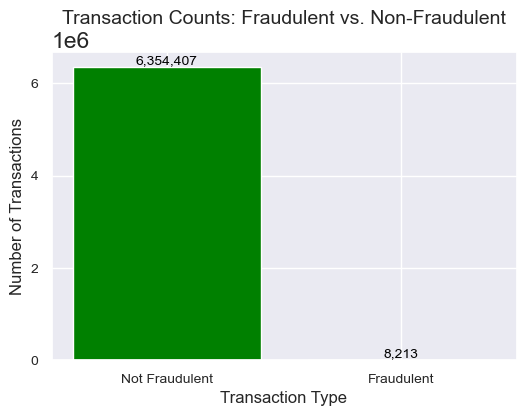

In [127]:
# Bar plot with annotations
plt.figure(figsize=(6, 4))
bars = plt.bar(is_fraud_counts.index, is_fraud_counts.values, color=['green', 'salmon'])

# Adding titles and labels
plt.title('Transaction Counts: Fraudulent vs. Non-Fraudulent', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xlabel('Transaction Type', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Annotating the total number on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height):,}', 
             ha='center', va='bottom', fontsize=10, color='black')

# Display the plot
plt.show()


ANOVA

In [ ]:
# Group the data by 'amount_map' and separate by category
very_low_transactions = df[df['amount_map'] == 'Very Low']['amount']
low_transactions = df[df['amount_map'] == 'Low']['amount']
medium_transactions = df[df['amount_map'] == 'Medium']['amount']
high_transactions = df[df['amount_map'] == 'High']['amount']
very_high_transactions = df[df['amount_map'] == 'Very High']['amount']

# Perform the one-way ANOVA test
f_stat, p_value = f_oneway(very_low_transactions, low_transactions, medium_transactions, high_transactions, very_high_transactions)

# Output the results
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

# Interpret the result
if p_value < 0.05:
    print("\nConclusion:")
    print("We reject the null hypothesis. There is a significant difference in the mean transaction amounts across the different categories.")
else:
    print("\nConclusion:")
    print("We fail to reject the null hypothesis. There is no significant difference in the mean transaction amounts across the different categories.")

F-statistic: 561557.7485018506
P-value: 0.0

Conclusion:
We reject the null hypothesis. There is a significant difference in the mean transaction amounts across the different categories.


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Combine the transaction amounts and their corresponding categories for Tukey's test
transaction_amounts = pd.concat([very_low_transactions, low_transactions, medium_transactions, high_transactions, very_high_transactions])
categories = ['Very Low'] * len(very_low_transactions) + ['Low'] * len(low_transactions) + \
             ['Medium'] * len(medium_transactions) + ['High'] * len(high_transactions) + ['Very High'] * len(very_high_transactions)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(transaction_amounts, categories, alpha=0.05)

# Display the results
print(tukey.summary())


           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
  group1    group2     meandiff   p-adj     lower         upper     reject
--------------------------------------------------------------------------
     High       Low  -228719.4926   0.0  -230791.1277  -226647.8574   True
     High    Medium  -155512.6746   0.0  -157309.1032  -153716.2459   True
     High Very High  1088767.8712   0.0  1086048.1223    1091487.62   True
     High  Very Low  -287852.8199   0.0  -289342.3464  -286363.2934   True
      Low    Medium     73206.818   0.0     71082.959     75330.677   True
      Low Very High  1317487.3637   0.0  1314541.0687  1320433.6588   True
      Low  Very Low   -59133.3274   0.0   -61004.7733   -57261.8814   True
   Medium Very High  1244280.5457   0.0  1241520.8105  1247040.2809   True
   Medium  Very Low  -132340.1454   0.0  -133901.4889  -130778.8018   True
Very High  Very Low -1376620.6911   0.0 -1379191.2302 -1374050.1519   True
-------------------------

All pairs show statistically significant differences (p-value = 0.0 for all comparisons), which means that the means of transaction amounts for each category are significantly different from the others.

# <h2 style= "color:#605f63;">Looking for Correlations with the Target </h2>

In [ ]:
num.corrwith(df["is_fraud"]).sort_values(ascending=False)

amount              0.08
step                0.03
old_balance_org     0.01
new_balance_dest    0.00
old_balance_dest   -0.01
new_balance_orig   -0.01
dtype: float64

In [ ]:
num2 = num.copy()
num2["is_fraud"] = df["is_fraud"]

In [ ]:
num2.corr(method="spearman")["is_fraud"].sort_values(ascending=False)

is_fraud            1.00
old_balance_org     0.04
amount              0.04
step                0.02
new_balance_dest   -0.01
old_balance_dest   -0.02
new_balance_orig   -0.03
Name: is_fraud, dtype: float64

# <h2 style= "color:#605f63;">Dealing with Multicollinearity </h2>

In [ ]:
num_corr = round(num.corr(), 2)

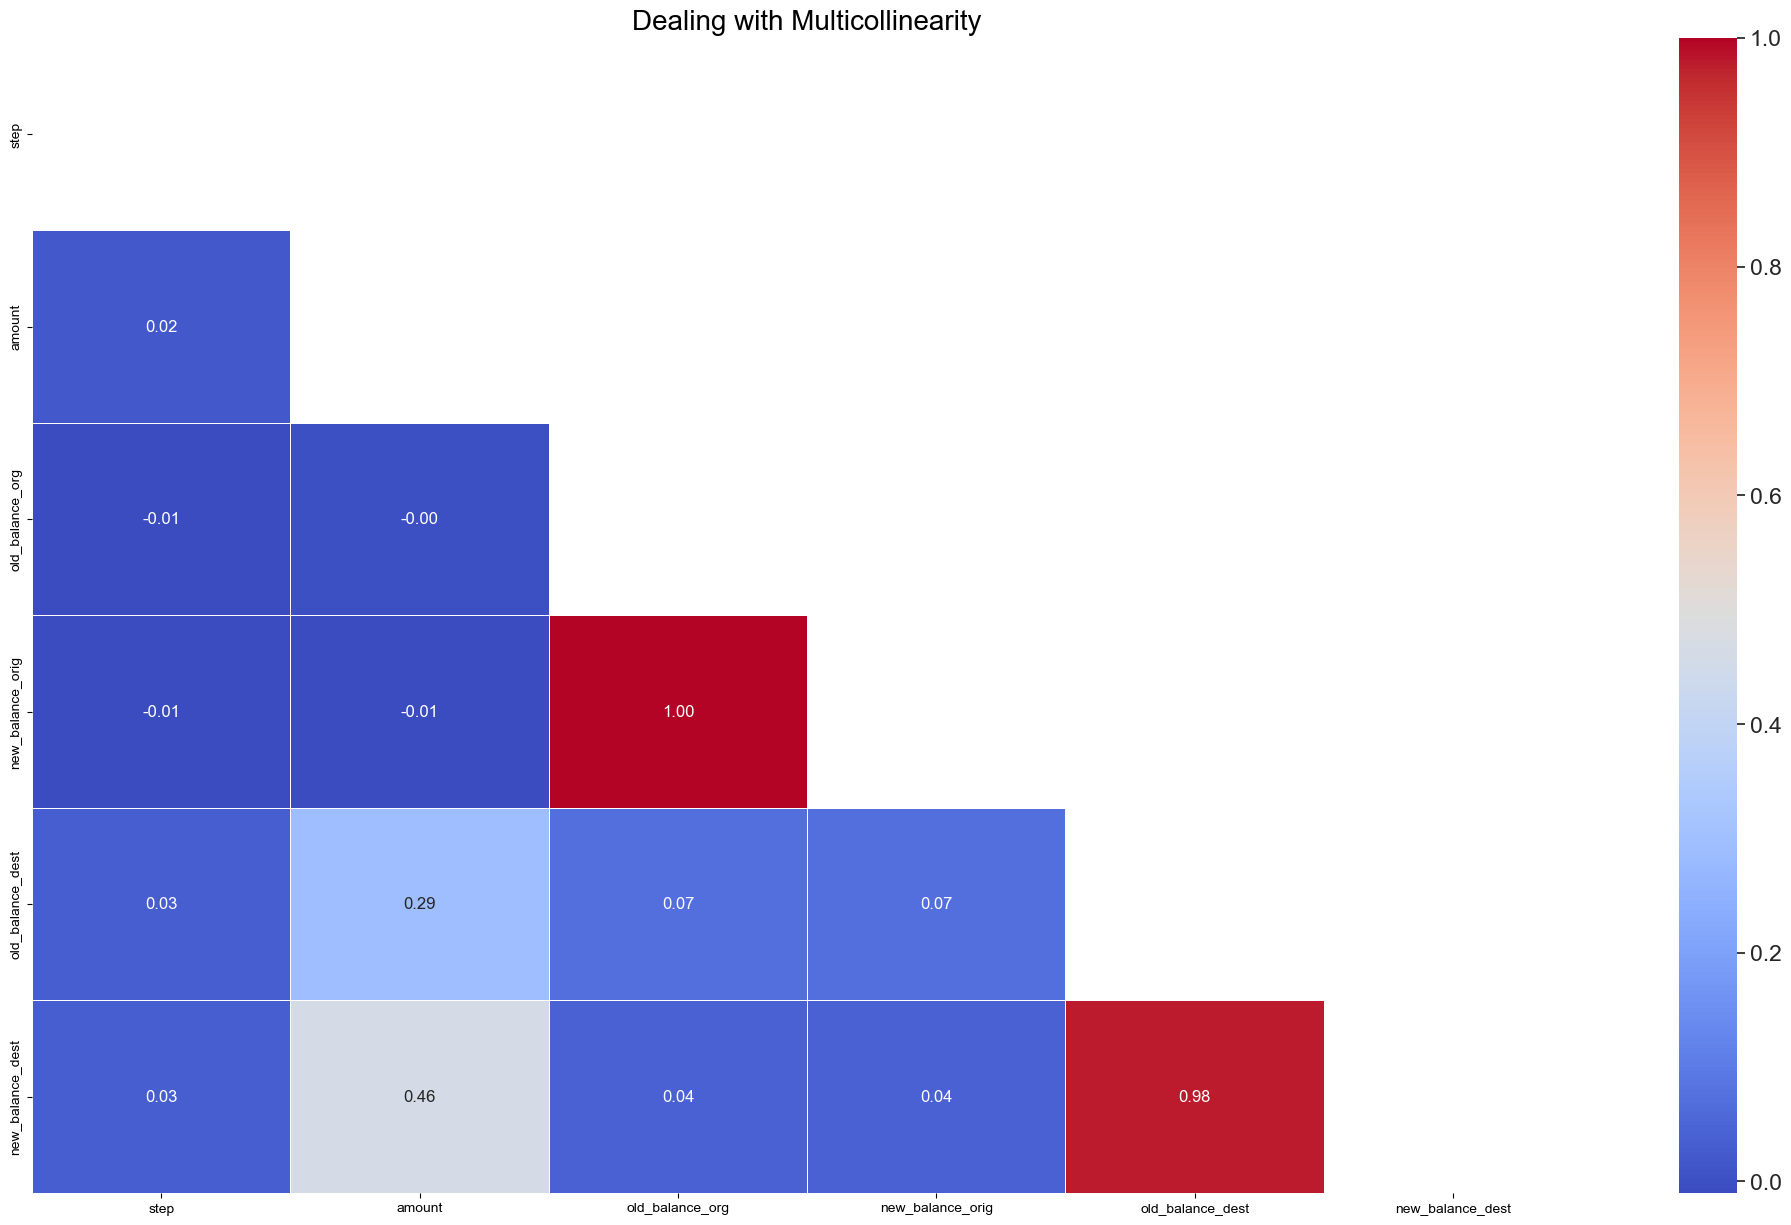

In [ ]:
# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

f, ax = plt.subplots(figsize=(25, 15))
sns.set(font_scale=1.5) # increase font size

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Dealing with Multicollinearity", fontsize=20) # add title
plt.show()

# <h2 style= "color:#605f63;">Feauture Engineering </h2>

In [ ]:
df2 = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]

In [ ]:
#Dropping columns for ML
df3 = df2.drop(["old_balance_org","new_balance_orig","old_balance_dest", "new_balance_dest", "name_orig","name_dest"],axis=1)
#df3 = df2.drop(["name_orig","name_dest"],axis=1)

In [ ]:
#Replace categoricals 
df3['type'].replace(to_replace=['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],value=[2,4,1,3,5],inplace=True)
df3['amount_map'].replace(to_replace=['Very Low','Low', 'Medium', 'High', 'Very High'],value=[0,1,2,3,4],inplace=True)

In [ ]:
df4 = df3.dropna()

# <h1 style= "color:#7496d6;">Modeling </h1>

In [ ]:
#df5 = df4.sample(10000)
df5 = df4.copy()

In [ ]:
df5 = df5.drop(['amount_map'],axis=1)

In [ ]:
df5.head()

,step,type,amount,is_fraud,is_flagged_fraud
2,1,4,181.00,1,0
3,1,1,181.00,1,0
15,1,1,229133.94,0,0
19,1,4,215310.30,0,0
24,1,4,311685.89,0,0


In [ ]:
df5.is_fraud.value_counts()

is_fraud
0    2762196
1       8197
Name: count, dtype: int64

In [ ]:
X = df5.drop("is_fraud", axis=1)
y = df5["is_fraud"]

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'100% of our data: {len(df5)}.')
print(f'70% for training data: {len(X_train)}.')
print(f'30% for test data: {len(X_test)}.')

100% of our data: 2770393.
70% for training data: 1939275.
30% for test data: 831118.


In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
model.score(X_test,y_test)

0.9969631267762219

In [ ]:
# Apply model to validation data
y_predict = model.predict(X_test)

In [ ]:
# Compare actual and predicted values
actual_vs_predict = pd.DataFrame({'Actual': y_test,
                                 'Predict': y_predict
                                 })
actual_vs_predict.sample(10)

,Actual,Predict
6338871,0,0
666866,0,0
5694039,0,0
1618212,0,0
5662845,0,0
5540588,0,0
6125361,0,0
1383641,0,0
3722696,0,0
1640291,0,0


In [ ]:
# Evaluate model
print('Classification metrics: \n', classification_report(y_test, y_predict))

Classification metrics: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    828654
           1       0.00      0.00      0.00      2464

    accuracy                           1.00    831118
   macro avg       0.50      0.50      0.50    831118
weighted avg       0.99      1.00      1.00    831118



Balancing 

In [ ]:
# Resample data ONLY using training data
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# View synthetic sample class distribution
print(pd.Series(y_resampled).value_counts())

is_fraud
0    1933542
1    1933542
Name: count, dtype: int64


In [ ]:
model = LogisticRegression()
model.fit(X_resampled, y_resampled)

LogisticRegression()

In [ ]:
model.score(X_resampled,y_resampled)


0.7513454582315771

In [ ]:
# Evaluate model
print('Classification metrics: \n', classification_report(y_test, y_predict))

Classification metrics: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    828654
           1       0.00      0.00      0.00      2464

    accuracy                           1.00    831118
   macro avg       0.50      0.50      0.50    831118
weighted avg       0.99      1.00      1.00    831118



Text(41.25, 0.5, 'Actual')

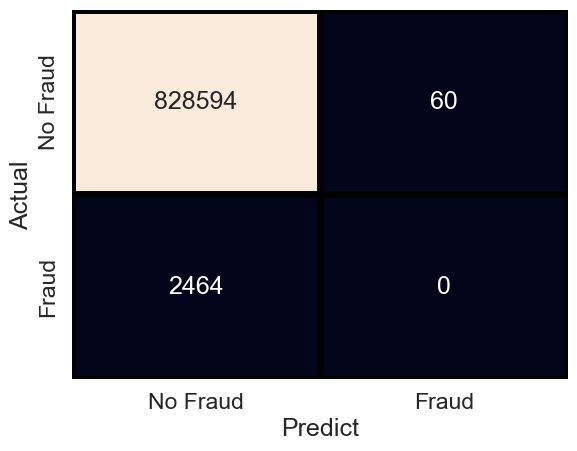

In [ ]:
# Compute confusion matrix
confusion_matrix
cm = confusion_matrix(y_test, y_predict)

sns.heatmap(cm, annot= True, fmt= 'd', cbar=False, linecolor='Black', linewidths=5)
plt.xticks(np.arange(2)+.5,['No Fraud', 'Fraud'])
plt.yticks(np.arange(2)+.5,['No Fraud', 'Fraud'])
plt.xlabel('Predict')
plt.ylabel('Actual')

Randon Under-sampling 

In [ ]:
count_class_0, count_class_1 = df5.is_fraud.value_counts()
df_class_0 = df5[df5["is_fraud"] == 0]
df_class_1 = df5[df5["is_fraud"] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df5 = pd.concat([df_class_0_under, df_class_1], axis=0)

print("Random under-sampling")
print(df5.is_fraud.value_counts())

Random under-sampling
is_fraud
0    8197
1    8197
Name: count, dtype: int64


In [ ]:
X = df5.drop(["is_fraud", "is_flagged_fraud"], axis=1)
y = df5["is_fraud"]

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'100% of our data: {len(df5)}.')
print(f'70% for training data: {len(X_train)}.')
print(f'30% for test data: {len(X_test)}.')

100% of our data: 16394.
70% for training data: 11475.
30% for test data: 4919.


<Axes: ylabel='count'>

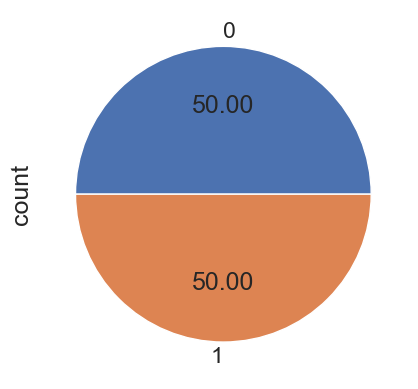

In [ ]:
y.value_counts().plot.pie(autopct='%.2f')

In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
model.score(X_test,y_test)

0.8078877820695263

In [ ]:
predictions = model.predict(X_test)

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      2462
           1       0.80      0.81      0.81      2457

    accuracy                           0.81      4919
   macro avg       0.81      0.81      0.81      4919
weighted avg       0.81      0.81      0.81      4919



In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
model.score(X_test,y_test)

0.7523886968896117

In [ ]:
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.73      0.81      0.77      2462
           1       0.79      0.69      0.74      2457

    accuracy                           0.75      4919
   macro avg       0.76      0.75      0.75      4919
weighted avg       0.76      0.75      0.75      4919



Text(41.25, 0.5, 'Actual')

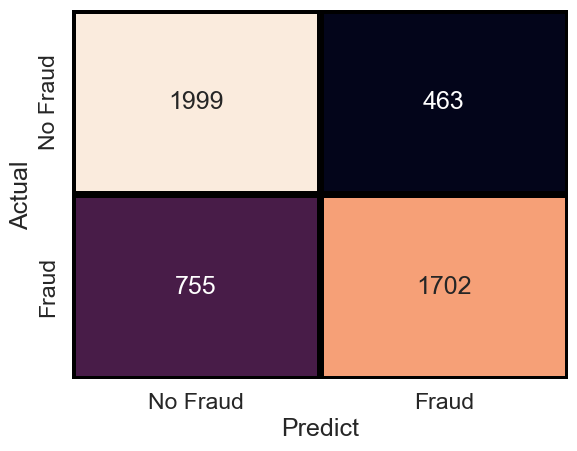

In [ ]:
# Compute confusion matrix
confusion_matrix
cm = confusion_matrix(y_test, predictions)

sns.heatmap(cm, annot= True, fmt= 'd', cbar=False, linecolor='Black', linewidths=5)
plt.xticks(np.arange(2)+.5,['No Fraud', 'Fraud'])
plt.yticks(np.arange(2)+.5,['No Fraud', 'Fraud'])
plt.xlabel('Predict')
plt.ylabel('Actual')

In [ ]:
#Linear Discriminant Analysis

model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)
# Apply model to validation data
y_predict = model.predict(X_test)
# Compare actual and predicted values
actual_vs_predict = pd.DataFrame({'Actual': y_test,
                                 'Predict': y_predict
                                 })
actual_vs_predict.sample(10)
# Evaluate model
print('Classification metrics: \n', classification_report(y_test, y_predict))

Classification metrics: 
               precision    recall  f1-score   support

           0       0.71      0.81      0.76      2462
           1       0.78      0.67      0.72      2457

    accuracy                           0.74      4919
   macro avg       0.74      0.74      0.74      4919
weighted avg       0.74      0.74      0.74      4919



In [ ]:
#GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
# Apply model to validation data
y_predict = model.predict(X_test)
# Compare actual and predicted values
actual_vs_predict = pd.DataFrame({'Actual': y_test,
                                 'Predict': y_predict
                                 })
actual_vs_predict.sample(10)
# Evaluate model
print('Classification metrics: \n', classification_report(y_test, y_predict))

Classification metrics: 
               precision    recall  f1-score   support

           0       0.63      0.94      0.76      2462
           1       0.89      0.45      0.59      2457

    accuracy                           0.69      4919
   macro avg       0.76      0.69      0.67      4919
weighted avg       0.76      0.69      0.67      4919



In [ ]:
#support vector machine 
model = SVC()
model.fit(X_train, y_train)
# Apply model to validation data
y_predict = model.predict(X_test)
# Compare actual and predicted values
actual_vs_predict = pd.DataFrame({'Actual': y_test,
                                 'Predict': y_predict
                                 })
actual_vs_predict.sample(10)
# Evaluate model
print('Classification metrics: \n', classification_report(y_test, y_predict))

Classification metrics: 
               precision    recall  f1-score   support

           0       0.61      0.93      0.74      2462
           1       0.86      0.41      0.56      2457

    accuracy                           0.67      4919
   macro avg       0.74      0.67      0.65      4919
weighted avg       0.74      0.67      0.65      4919



In [ ]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
# Apply model to validation data
y_predict = model.predict(X_test)
# Compare actual and predicted values
actual_vs_predict = pd.DataFrame({'Actual': y_test,
                                 'Predict': y_predict
                                 })
actual_vs_predict.sample(10)
# Evaluate model
print('Classification metrics: \n', classification_report(y_test, y_predict))

Classification metrics: 
               precision    recall  f1-score   support

           0       0.70      0.76      0.73      2462
           1       0.73      0.67      0.70      2457

    accuracy                           0.71      4919
   macro avg       0.72      0.71      0.71      4919
weighted avg       0.72      0.71      0.71      4919



In [ ]:
# Save the processed data to a CSV file
num.to_csv('num.csv', index=True)  # Include index if needed

In [ ]:
# Save the processed data to a CSV file
df.to_csv('df.csv', index=True)  # Include index if needed

In [ ]:
# Save the processed data to a CSV file
df5.to_csv('df5.csv', index=True)  # Include index if needed